In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("/Users/ibragimzhussup/Desktop/APA_Lab/src/modules")
from preprocess import PreprocessAPA
from ML_models import ML_Models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
df = pd.read_csv("../data/prep_t.csv")
df = df.dropna()

In [24]:
prep = PreprocessAPA()
train, test = prep.split_data(df, test_val=False, n_samples_train=500)
test_sampled, _ = train_test_split(test, train_size=500, stratify=test['labels'], random_state=123)

<Axes: title={'center': 'Label Dist. Original Data'}>

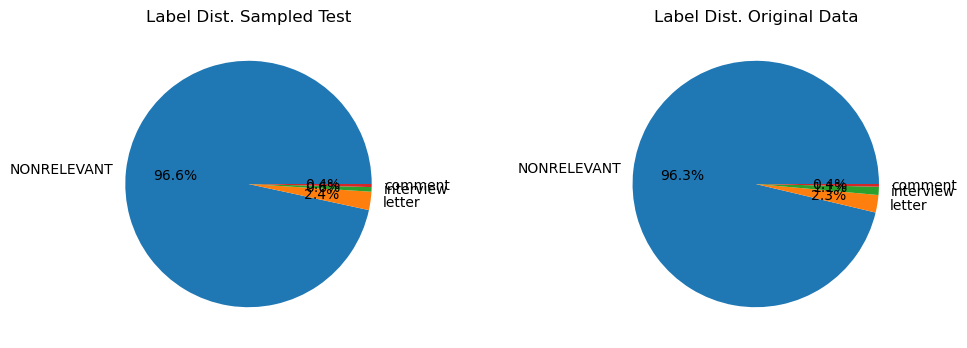

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
test_sampled['labels'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax[0], ylabel="", title="Label Dist. Sampled Test")
df['labels'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax[1], ylabel="", title="Label Dist. Original Data")

In [39]:
total = len(train) + len(test_sampled)
print(f"Trainset: {(len(train)/total)*100}%\nTestset: {(len(test_sampled)/total)*100}%")

Trainset: 80.0%
Testset: 20.0%


# ML Testing

In [40]:
ml = ML_Models()

In [41]:
performance = ml.run(train=train, test=test_sampled)

Logistic Regression
              precision    recall  f1-score   support

           0       0.07      1.00      0.12         3
           1       1.00      0.83      0.91       483
           2       1.00      0.83      0.91        12
           3       0.05      1.00      0.09         2

    accuracy                           0.83       500
   macro avg       0.53      0.92      0.51       500
weighted avg       0.99      0.83      0.90       500


Random Forest
              precision    recall  f1-score   support

           0       0.08      1.00      0.15         3
           1       1.00      0.81      0.90       483
           2       0.43      1.00      0.60        12
           3       0.05      1.00      0.09         2

    accuracy                           0.82       500
   macro avg       0.39      0.95      0.43       500
weighted avg       0.98      0.82      0.88       500


Naive Bayes
              precision    recall  f1-score   support

           0       0.01    

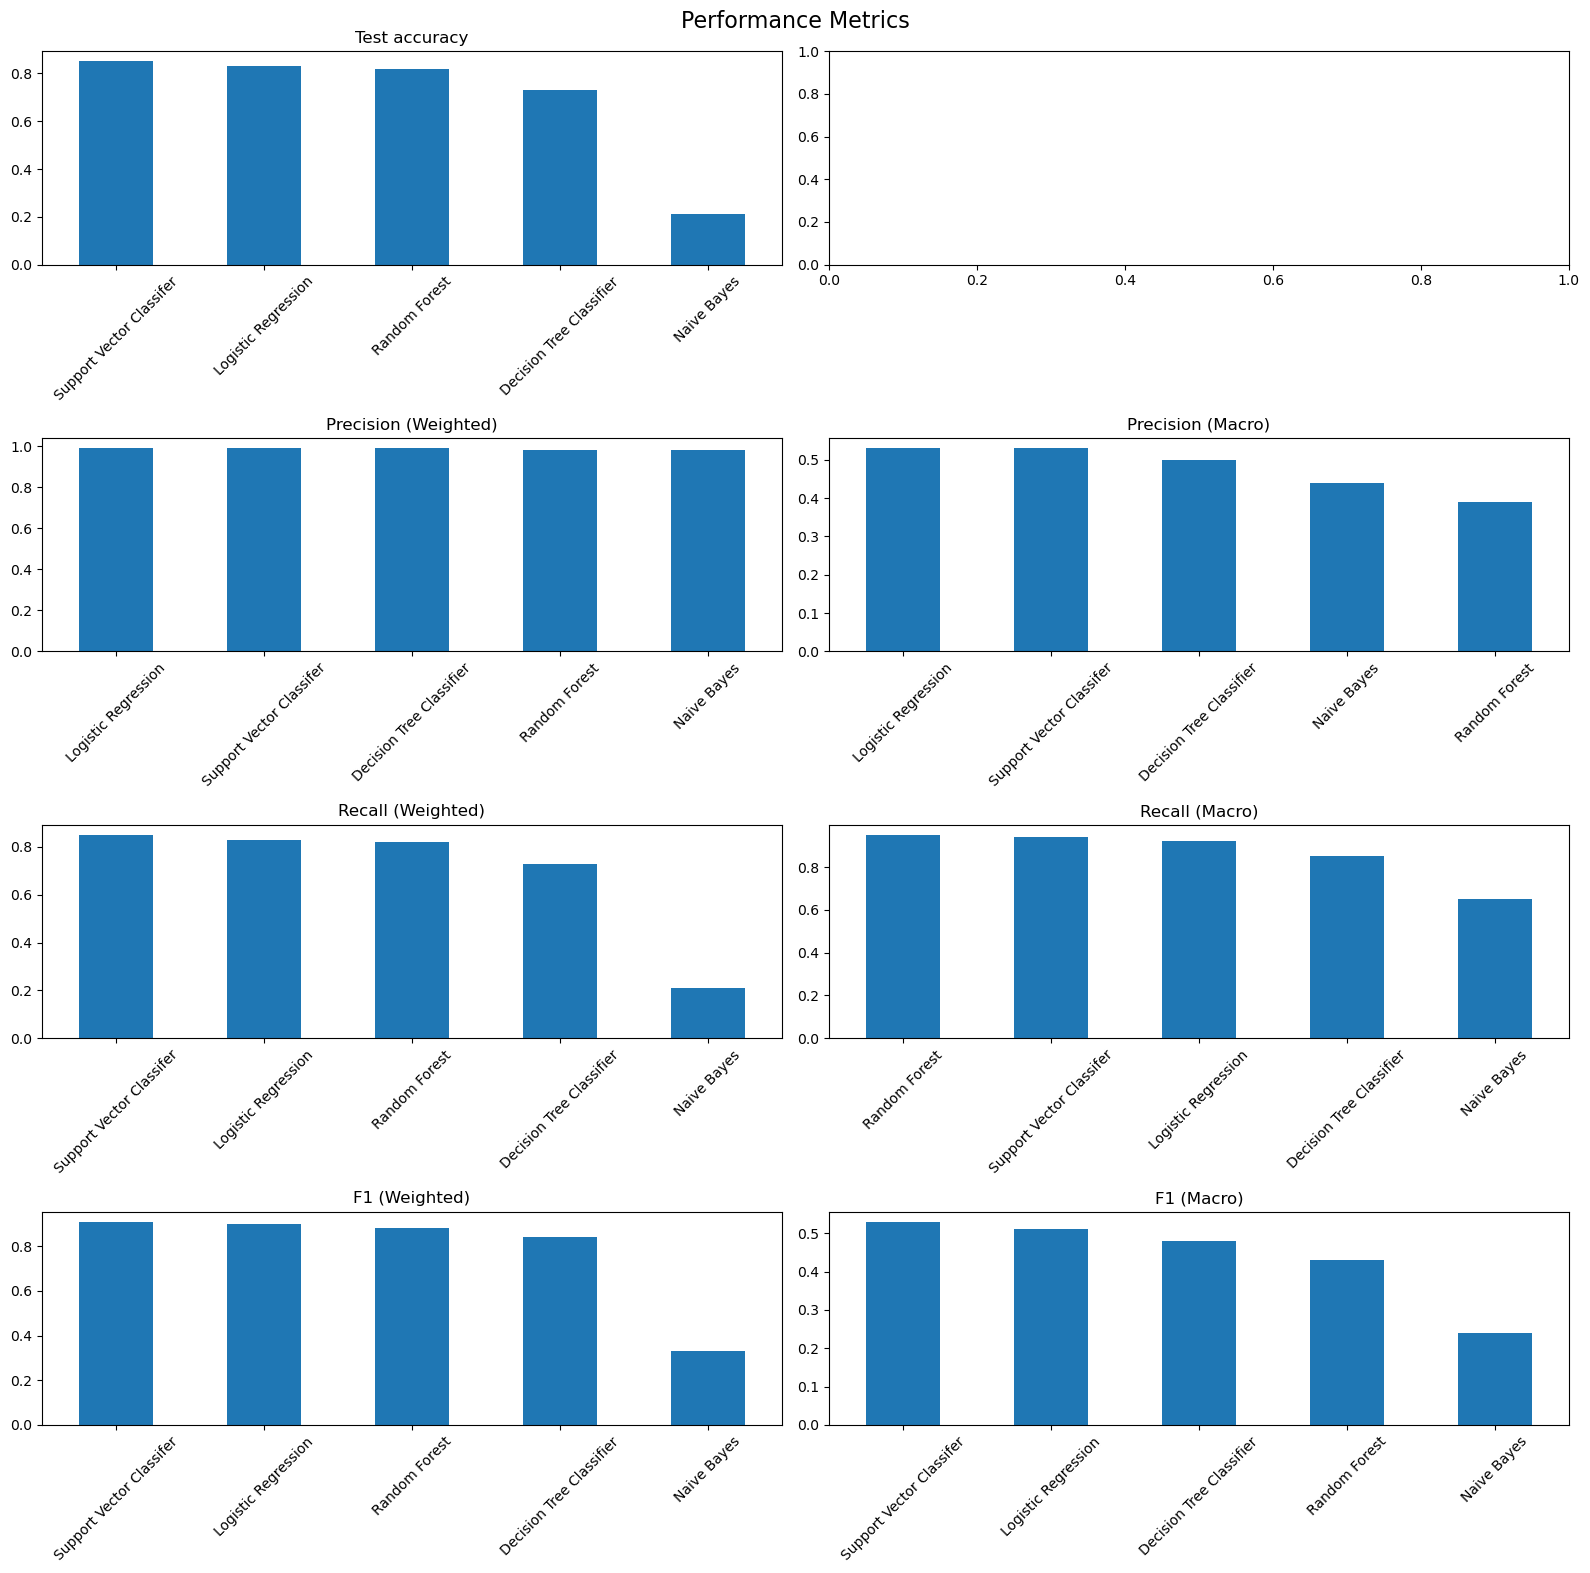

In [42]:
ml.plot_performance(performance, average_val="both")

**Very much the same as the previous results**

# DL Testing

In [43]:
import tensorflow as tf
import tensorflow_hub as hub
from DL_models import RNN, CNN
hub_layer_de_128 = hub.KerasLayer("https://www.kaggle.com/models/google/nnlm/frameworks/TensorFlow2/variations/de-dim128/versions/1",
                            dtype=tf.string, trainable=False, input_shape=[])

In [44]:
lstm = RNN()
lstm.embedding = hub_layer_de_128
lstm.tokenize(train, test_sampled)
X_train, X_test, y_train, y_test = lstm.pad_and_label_preproc()
lstm_model, early_stop = lstm.build_model(use_basic_embed=False, optimizer="adam", reshape=128)

Attributes updated, use <self.train_seq> etc. to use values
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               125307520 
                                                                 
 reshape (Reshape)           (None, 1, 128)            0         
                                                                 
 bidirectional (Bidirection  (None, 1, 256)            263168    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1, 256)            0         
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                              

In [45]:
lstm_model.fit(train['text'], y_train, batch_size=64,
               epochs=100, callbacks=[early_stop], validation_data=(test_sampled['text'],
                                                                    y_test))

Epoch 1/100
32/32 [==============================] - 8s 82ms/step - loss: 1.2947 - accuracy: 0.3210 - val_loss: 1.3440 - val_accuracy: 0.6080
Epoch 2/100
32/32 [==============================] - 1s 28ms/step - loss: 1.0851 - accuracy: 0.5700 - val_loss: 0.9987 - val_accuracy: 0.7060
Epoch 3/100
32/32 [==============================] - 1s 28ms/step - loss: 0.8801 - accuracy: 0.6535 - val_loss: 0.7718 - val_accuracy: 0.7360
Epoch 4/100
32/32 [==============================] - 1s 28ms/step - loss: 0.8004 - accuracy: 0.6905 - val_loss: 0.7058 - val_accuracy: 0.7420
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 0.7408 - accuracy: 0.7090 - val_loss: 0.7333 - val_accuracy: 0.6920
Epoch 6/100
32/32 [==============================] - 1s 27ms/step - loss: 0.7187 - accuracy: 0.7230 - val_loss: 0.6694 - val_accuracy: 0.7480
Epoch 7/100
32/32 [==============================] - 1s 18ms/step - loss: 0.6868 - accuracy: 0.7335 - val_loss: 0.6725 - val_accuracy: 0.7480
Epoch 

In [48]:
print("Test set")
print(classification_report(np.argmax(y_test, axis=1), 
                            np.argmax(lstm_model.predict(test_sampled['text']), axis=1)))

Test set
16/16 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.07      1.00      0.14         3
           1       1.00      0.80      0.89       483
           2       0.20      0.58      0.30        12
           3       0.03      0.50      0.05         2

    accuracy                           0.80       500
   macro avg       0.32      0.72      0.34       500
weighted avg       0.97      0.80      0.87       500



In [50]:
cnn = CNN()
cnn.embedding = hub_layer_de_128
cnn_model, early_stop = cnn.build_model(use_basic_embed=False, reshape=128, optimizer="adam", add_globalmaxpool=True)

Using custom embedding
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               125307520 
                                                                 
 reshape_1 (Reshape)         (None, 1, 128)            0         
                                                                 
 dropout_4 (Dropout)         (None, 1, 128)            0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            49280     
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             24640     
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 32)             6176      
                                                                 
 global_max_pooling1d_1 (Gl  (N

In [51]:
cnn_model.fit(train['text'], y_train, batch_size=64,
               epochs=100, callbacks=[early_stop], validation_data=(test_sampled['text'],
                                                                    y_test))

Epoch 1/100
32/32 [==============================] - 3s 51ms/step - loss: 1.3018 - accuracy: 0.3085 - val_loss: 1.3849 - val_accuracy: 0.6520
Epoch 2/100
32/32 [==============================] - 1s 26ms/step - loss: 1.0752 - accuracy: 0.5570 - val_loss: 0.8487 - val_accuracy: 0.7880
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.8758 - accuracy: 0.6445 - val_loss: 0.8746 - val_accuracy: 0.6940
Epoch 4/100
32/32 [==============================] - 1s 23ms/step - loss: 0.8089 - accuracy: 0.6745 - val_loss: 0.8189 - val_accuracy: 0.6860
Epoch 5/100
32/32 [==============================] - 1s 24ms/step - loss: 0.7508 - accuracy: 0.7085 - val_loss: 0.5896 - val_accuracy: 0.7760
Epoch 6/100
32/32 [==============================] - 0s 10ms/step - loss: 0.7316 - accuracy: 0.7105 - val_loss: 0.7770 - val_accuracy: 0.6740
Epoch 7/100
32/32 [==============================] - 0s 10ms/step - loss: 0.6875 - accuracy: 0.7455 - val_loss: 0.7199 - val_accuracy: 0.7060
Epoch 

In [52]:
print("Test set")
print(classification_report(np.argmax(y_test, axis=1), 
                            np.argmax(cnn_model.predict(test_sampled['text']), axis=1)))

Test set
16/16 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.07      1.00      0.12         3
           1       0.99      0.78      0.87       483
           2       0.20      0.67      0.30        12
           3       0.03      0.50      0.06         2

    accuracy                           0.78       500
   macro avg       0.32      0.74      0.34       500
weighted avg       0.96      0.78      0.85       500



# SETFIT Test

In [65]:
from setfit import SetFitModel, Trainer, TrainingArguments
from datasets import Dataset

In [58]:
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-MiniLM-L6-v2")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [60]:
test_dataset = Dataset.from_dict({"text": test['text'], "label": test['label_ids']}) 
train_dataset = Dataset.from_dict({"text": train["text"], "label": train['label_ids']}) 

In [66]:
args = TrainingArguments(
    num_iterations = 5
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

/Users/ibragimzhussup/anaconda3/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [68]:
trainer.train()

***** Running training *****
  Num unique pairs = 20000
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 1250
/Users/ibragimzhussup/anaconda3/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1250 [00:00<?, ?it/s]

/Users/ibragimzhussup/anaconda3/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1250 [00:00<?, ?it/s]

{'embedding_loss': 0.2543, 'learning_rate': 1.6e-07, 'epoch': 0.0}


RuntimeError: MPS backend out of memory (MPS allocated: 1.30 GB, other allocations: 2.10 GB, max allowed: 3.40 GB). Tried to allocate 12.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).